In [1]:
import numpy as np
import pandas as pd
import os
import pdb
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from promoter_modelling.utils import diversity

np.random.seed(97)

In [2]:
final_sequences = pd.read_parquet("final_sequences_v6.parquet")

In [3]:
final_sequences["experiment_id"] = final_sequences.apply(lambda x: f'{x["design_model"]}_{x["target_cell_exp_weight"]}_{x["diversity_loss_coef"]}', axis=1)

In [4]:
final_sequences

,designed_for,sequence,design_model,target_cell_exp_weight,diversity_loss_coef,entropy_loss_coef,THP1,Jurkat,K562,experiment_id
0,THP1,CGACGCCAACCGAGGAAACGGAAGCAGAAGCAGAAGCAGAAGCGAA...,coms_0.03_total_rounds_3_gd_steps_10_mutation_...,1.5,1.0,1.0,1.629622,0.379506,0.336685,coms_0.03_total_rounds_3_gd_steps_10_mutation_...
1,THP1,CGACGCCAACCGAGGAAGCGGAAGCAGAAGCAGAAGCAGAAGCAGA...,coms_0.03_total_rounds_3_gd_steps_10_mutation_...,1.5,1.0,1.0,1.687961,0.559623,0.479022,coms_0.03_total_rounds_3_gd_steps_10_mutation_...
2,THP1,CGACGCCAACCGAGGAAACCGAAGCGGAAGCAGAAGCTGAAGCAGA...,coms_0.03_total_rounds_3_gd_steps_10_mutation_...,1.5,1.0,1.0,1.599566,0.389701,0.326611,coms_0.03_total_rounds_3_gd_steps_10_mutation_...
3,THP1,CGACGCCAACCGAGGAAACGGAAGCAGAAGCAGAAGCAGAAGCAGA...,coms_0.03_total_rounds_3_gd_steps_10_mutation_...,1.5,1.0,1.0,1.664889,0.414526,0.354171,coms_0.03_total_rounds_3_gd_steps_10_mutation_...
4,THP1,CGACGCCAACCGAGGAAACAGAAGGAAACGGAAGCAGAAGCAGAAG...,coms_0.03_total_rounds_3_gd_steps_10_mutation_...,1.5,1.0,1.0,1.853674,0.618269,0.605900,coms_0.03_total_rounds_3_gd_steps_10_mutation_...
...,...,...,...,...,...,...,...,...,...,...
4679995,K562,GGGGGGCGTGTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...,coms_0.3_total_rounds_5_gd_steps_5_mutation_st...,2.0,10.0,10.0,0.676364,0.917514,1.550400,coms_0.3_total_rounds_5_gd_steps_5_mutation_st...
4679996,K562,GCCCCTTTTCTTTTGGGGGGGGGGGGGGGGGGGGGGGGGCCCCTTT...,coms_0.3_total_rounds_5_gd_steps_5_mutation_st...,2.0,10.0,10.0,0.615660,0.885715,1.572785,coms_0.3_total_rounds_5_gd_steps_5_mutation_st...
4679997,K562,TTTTTTGGGGGGGGGGGGGGGGCGGGACCCCCTTTTTTTTTTTTTT...,coms_0.3_total_rounds_5_gd_steps_5_mutation_st...,2.0,10.0,10.0,0.583300,0.760906,1.487105,coms_0.3_total_rounds_5_gd_steps_5_mutation_st...
4679998,K562,GCGCCTTCTTTTTCGGGGGGGGGGGGGGGGCGGGGGGGCGGGGCGC...,coms_0.3_total_rounds_5_gd_steps_5_mutation_st...,2.0,10.0,10.0,0.738684,1.216584,1.762630,coms_0.3_total_rounds_5_gd_steps_5_mutation_st...


In [5]:
all_cells = ["THP1", "Jurkat", "K562"]
all_experiment_ids = list(set(final_sequences["experiment_id"]))

In [7]:
all_pairwise_edit_distances = {}
all_pairwise_edit_distances["experiment_id"] = []
all_pairwise_edit_distances["designed_for"] = []
all_pairwise_edit_distances["mean_pairwise_edit_distance"] = []

all_pairwise_edit_distances["avg_target_cell_exp"] = []
all_pairwise_edit_distances["avg_diff"] = []

all_pairwise_edit_distances["target_cell_exp_weight"] = []
all_pairwise_edit_distances["diversity_loss_coef"] = []

all_pairwise_edit_distances["coms_alpha"] = []
all_pairwise_edit_distances["coms_total_rounds"] = []
all_pairwise_edit_distances["coms_mutation_steps"] = []

for cell in all_cells:
    print(cell)
    other_cells = [c for c in ["THP1", "Jurkat", "K562"] if c != cell]
    print(other_cells)
    
    for exp in tqdm(all_experiment_ids):
#         print(exp)
        subset = final_sequences[(final_sequences["designed_for"] == cell) & (final_sequences["experiment_id"] == exp)].reset_index(drop=True)
        if subset.shape[0] == 0:
            continue
        
        # randomly sample some sequences
        random_sample = np.random.randint(0, len(subset), 500)
        subset = subset.iloc[random_sample]
#         print(subset.shape)
        
        # get their average pairwise edit distance
        random_seqs = list(subset["sequence"])
#         print(len(random_seqs))
        mean_pairwise_edit_distance = diversity.compute_average_pairwise_edit_distance(random_seqs)[0]
        
        # get their average exp and diff
        avg_target_cell_exp = subset[cell].mean()
        avg_diff = (subset[cell] - np.max(subset[other_cells], axis=1)).mean()
        
        # hyperparams
        target_cell_exp_weight = float(exp.split("_")[-2])
        diversity_loss_coef = float(exp.split("_")[-1])
        coms_alpha = float(exp.split("_")[1])
        coms_total_rounds = float(exp.split("_")[4])
        coms_mutation_steps = float(exp.split("_")[10][:-len(".pkl")])
        
        # add everything to the dataframe
        all_pairwise_edit_distances["experiment_id"].append(exp)
        all_pairwise_edit_distances["designed_for"].append(cell)
        all_pairwise_edit_distances["mean_pairwise_edit_distance"].append(mean_pairwise_edit_distance)
        
        all_pairwise_edit_distances["avg_target_cell_exp"].append(avg_target_cell_exp)
        all_pairwise_edit_distances["avg_diff"].append(avg_diff)
        
        all_pairwise_edit_distances["target_cell_exp_weight"].append(target_cell_exp_weight)
        all_pairwise_edit_distances["diversity_loss_coef"].append(diversity_loss_coef)
        all_pairwise_edit_distances["coms_alpha"].append(coms_alpha)
        all_pairwise_edit_distances["coms_total_rounds"].append(coms_total_rounds)
        all_pairwise_edit_distances["coms_mutation_steps"].append(coms_mutation_steps)

THP1
['Jurkat', 'K562']


100%|█████████████████████████████████████████| 156/156 [01:54<00:00,  1.36it/s]


Jurkat
['THP1', 'K562']


100%|█████████████████████████████████████████| 156/156 [01:57<00:00,  1.32it/s]


K562
['THP1', 'Jurkat']


100%|█████████████████████████████████████████| 156/156 [01:59<00:00,  1.31it/s]


In [8]:
all_pairwise_edit_distances = pd.DataFrame(all_pairwise_edit_distances)

In [9]:
all_pairwise_edit_distances

,experiment_id,designed_for,mean_pairwise_edit_distance,avg_target_cell_exp,avg_diff,target_cell_exp_weight,diversity_loss_coef,coms_alpha,coms_total_rounds,coms_mutation_steps
0,coms_0.1_total_rounds_5_gd_steps_5_mutation_st...,THP1,126.391214,0.191461,0.404603,2.00,10.0,0.10,5.0,5.0
1,coms_0.03_total_rounds_3_gd_steps_3_mutation_s...,THP1,131.902301,1.434080,0.598934,1.50,5.0,0.03,3.0,3.0
2,coms_0.03_total_rounds_5_gd_steps_5_mutation_s...,THP1,61.547944,2.091958,1.136891,1.50,1.0,0.03,5.0,5.0
3,coms_0.1_total_rounds_3_gd_steps_3_mutation_st...,THP1,41.935671,0.747180,0.595471,2.00,1.0,0.10,3.0,3.0
4,coms_0.1_total_rounds_5_gd_steps_10_mutation_s...,THP1,138.417900,0.266166,0.295900,2.00,5.0,0.10,5.0,10.0
...,...,...,...,...,...,...,...,...,...,...
229,coms_0.3_total_rounds_5_gd_steps_5_mutation_st...,K562,54.676986,2.408746,1.422206,2.00,1.0,0.30,5.0,5.0
230,coms_0.3_total_rounds_5_gd_steps_10_mutation_s...,K562,56.487583,2.246505,1.082578,2.00,1.0,0.30,5.0,10.0
231,coms_0.1_total_rounds_5_gd_steps_10_mutation_s...,K562,19.655335,3.211375,2.036793,2.00,1.0,0.10,5.0,10.0
232,coms_0.3_total_rounds_3_gd_steps_3_mutation_st...,K562,30.763912,2.629782,2.012971,1.15,1.0,0.30,3.0,3.0


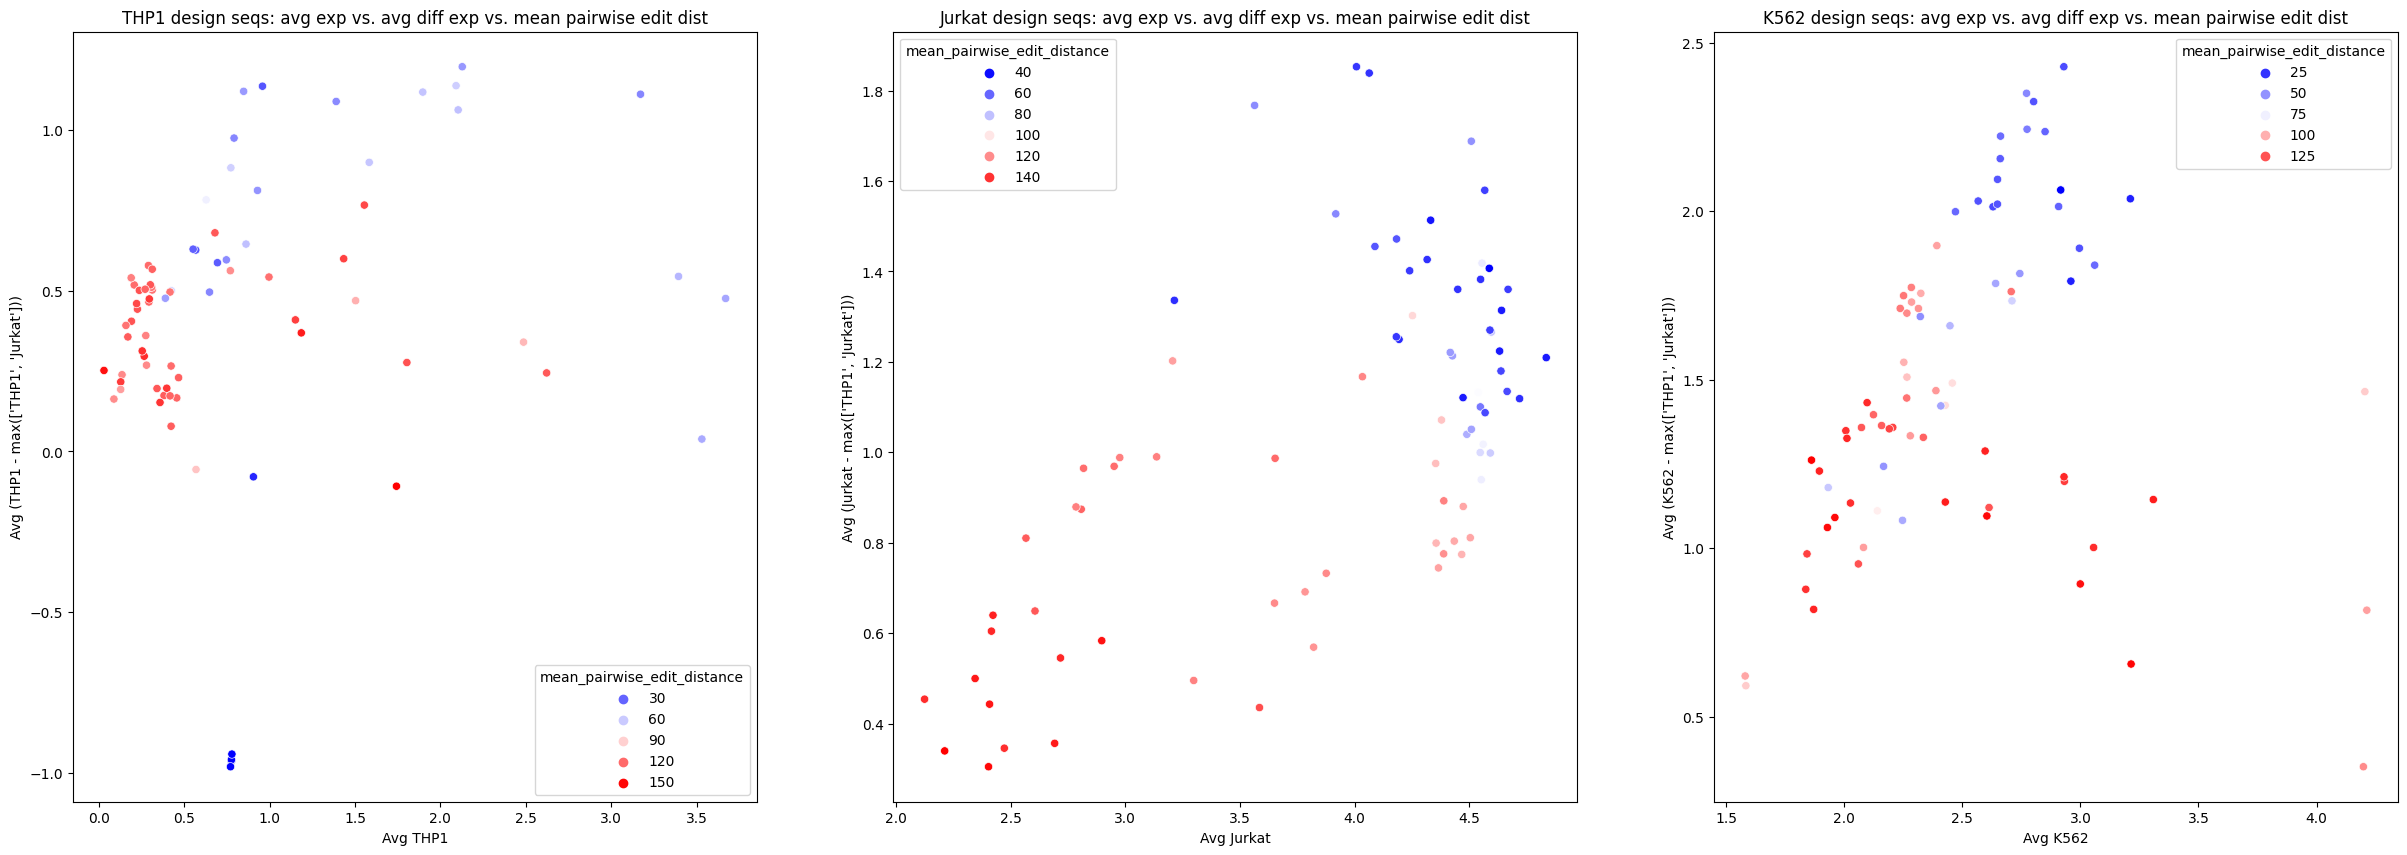

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10))

for i, cell in enumerate(all_cells):
    subset = all_pairwise_edit_distances[all_pairwise_edit_distances["designed_for"] == cell].reset_index(drop=True)
#     subset["index"] = subset.index
#     fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#     sns.scatterplot(data=subset, x="mean_pairwise_edit_distance", y="avg_diff", ax=ax[0], hue="index", legend=False, palette="Set1")
#     sns.scatterplot(data=subset, x="mean_pairwise_edit_distance", y="avg_target_cell_exp", ax=ax[1], hue="index", legend=False, palette="Set1")
#     fig.suptitle(cell)
#     plt.show()
    
#     fig = plt.figure()
# #     ax = Axes3D(fig)
#     ax = fig.add_subplot(projection='3d')
    
#     ax.scatter(subset["mean_pairwise_edit_distance"], subset["avg_diff"], subset["avg_target_cell_exp"])
#     ax.set_xlabel("mean_pairwise_edit_distance")    
#     ax.set_ylabel("avg_diff")    
#     ax.set_zlabel("avg_target_cell_exp")    
#     fig.suptitle(cell)
#     plt.show()

    sns.scatterplot(data=subset, x="avg_target_cell_exp", y="avg_diff", hue="mean_pairwise_edit_distance", palette="bwr", ax=ax[i])
    ax[i].set_title(f"{cell} design seqs: avg exp vs. avg diff exp vs. mean pairwise edit dist")
    ax[i].set_xlabel(f"Avg {cell}")
    ax[i].set_ylabel(f"Avg ({cell} - max({other_cells}))")

plt.show()

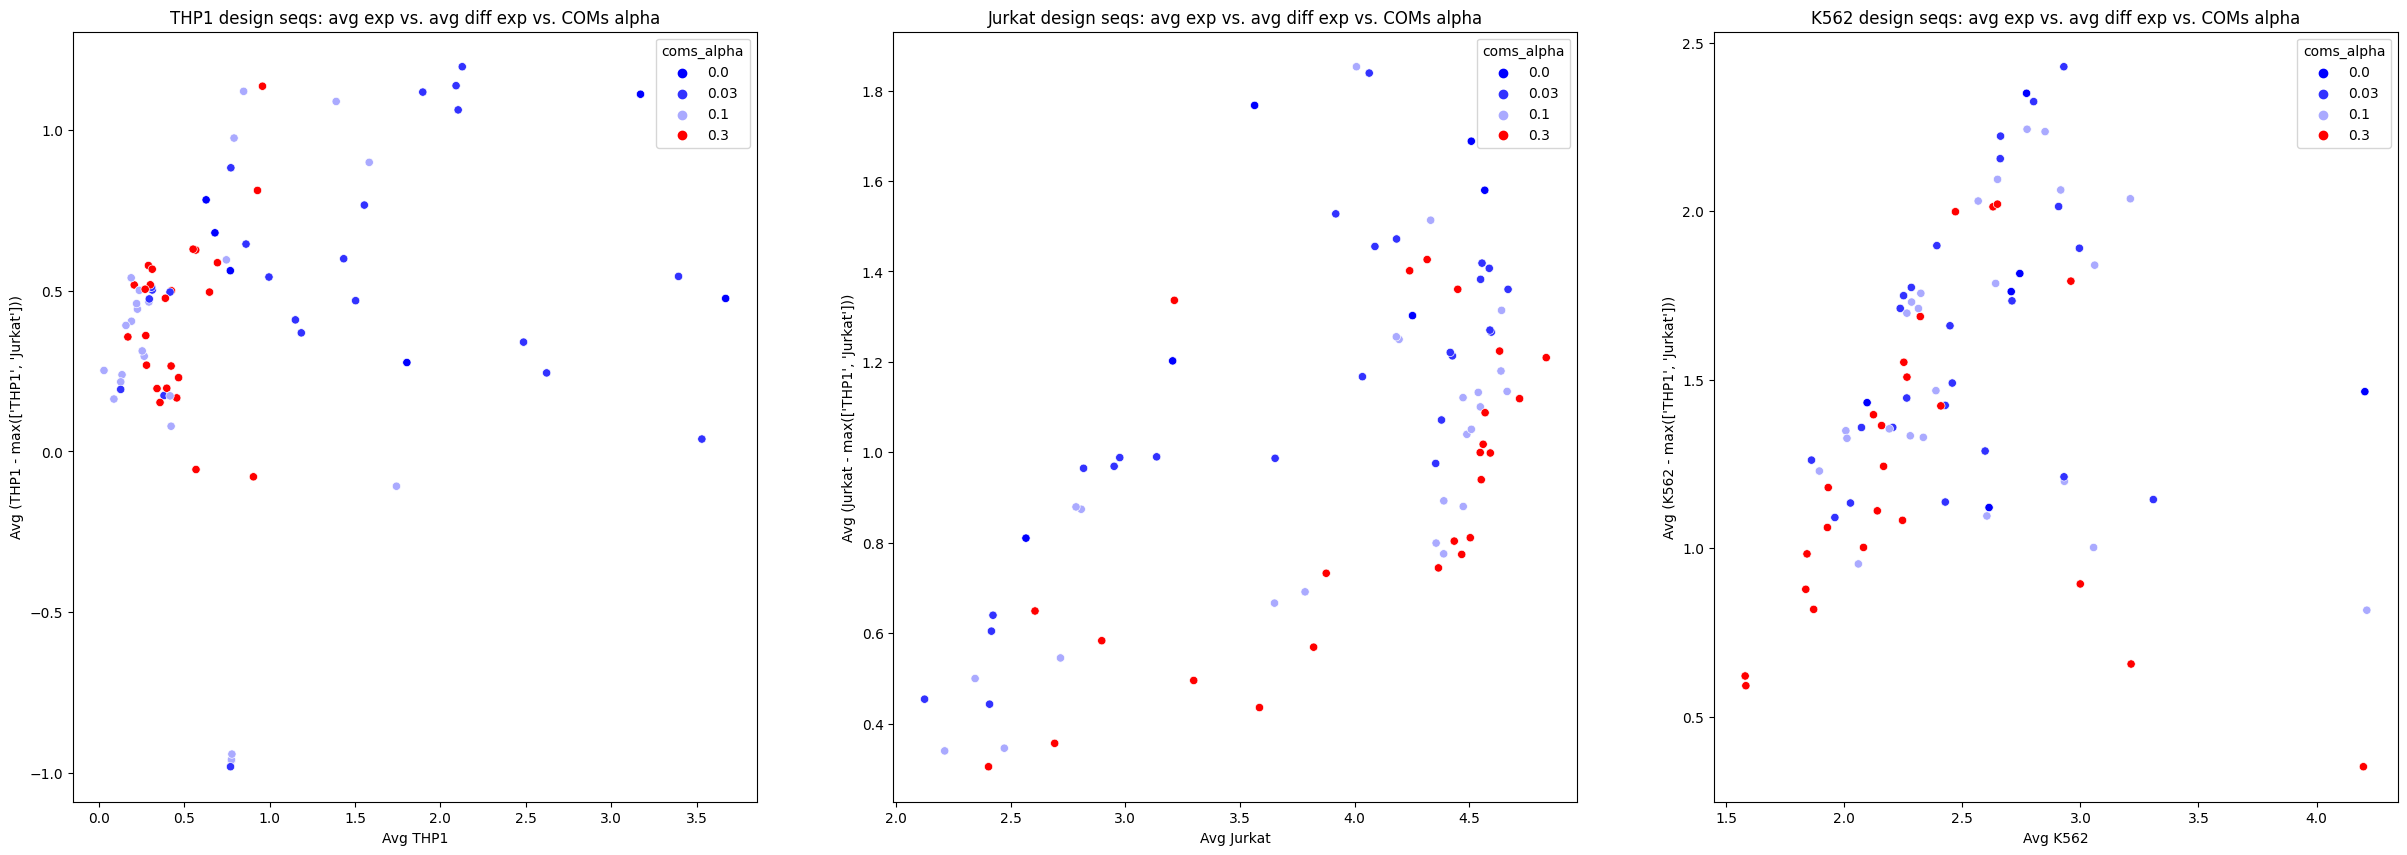

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10))

for i, cell in enumerate(all_cells):
    subset = all_pairwise_edit_distances[all_pairwise_edit_distances["designed_for"] == cell].reset_index(drop=True)
#     subset["index"] = subset.index
#     fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#     sns.scatterplot(data=subset, x="mean_pairwise_edit_distance", y="avg_diff", ax=ax[0], hue="index", legend=False, palette="Set1")
#     sns.scatterplot(data=subset, x="mean_pairwise_edit_distance", y="avg_target_cell_exp", ax=ax[1], hue="index", legend=False, palette="Set1")
#     fig.suptitle(cell)
#     plt.show()
    
#     fig = plt.figure()
# #     ax = Axes3D(fig)
#     ax = fig.add_subplot(projection='3d')
    
#     ax.scatter(subset["mean_pairwise_edit_distance"], subset["avg_diff"], subset["avg_target_cell_exp"])
#     ax.set_xlabel("mean_pairwise_edit_distance")    
#     ax.set_ylabel("avg_diff")    
#     ax.set_zlabel("avg_target_cell_exp")    
#     fig.suptitle(cell)
#     plt.show()

    sns.scatterplot(data=subset, x="avg_target_cell_exp", y="avg_diff", hue="coms_alpha", palette="bwr", ax=ax[i])
    ax[i].set_title(f"{cell} design seqs: avg exp vs. avg diff exp vs. COMs alpha")
    ax[i].set_xlabel(f"Avg {cell}")
    ax[i].set_ylabel(f"Avg ({cell} - max({other_cells}))")

plt.show()

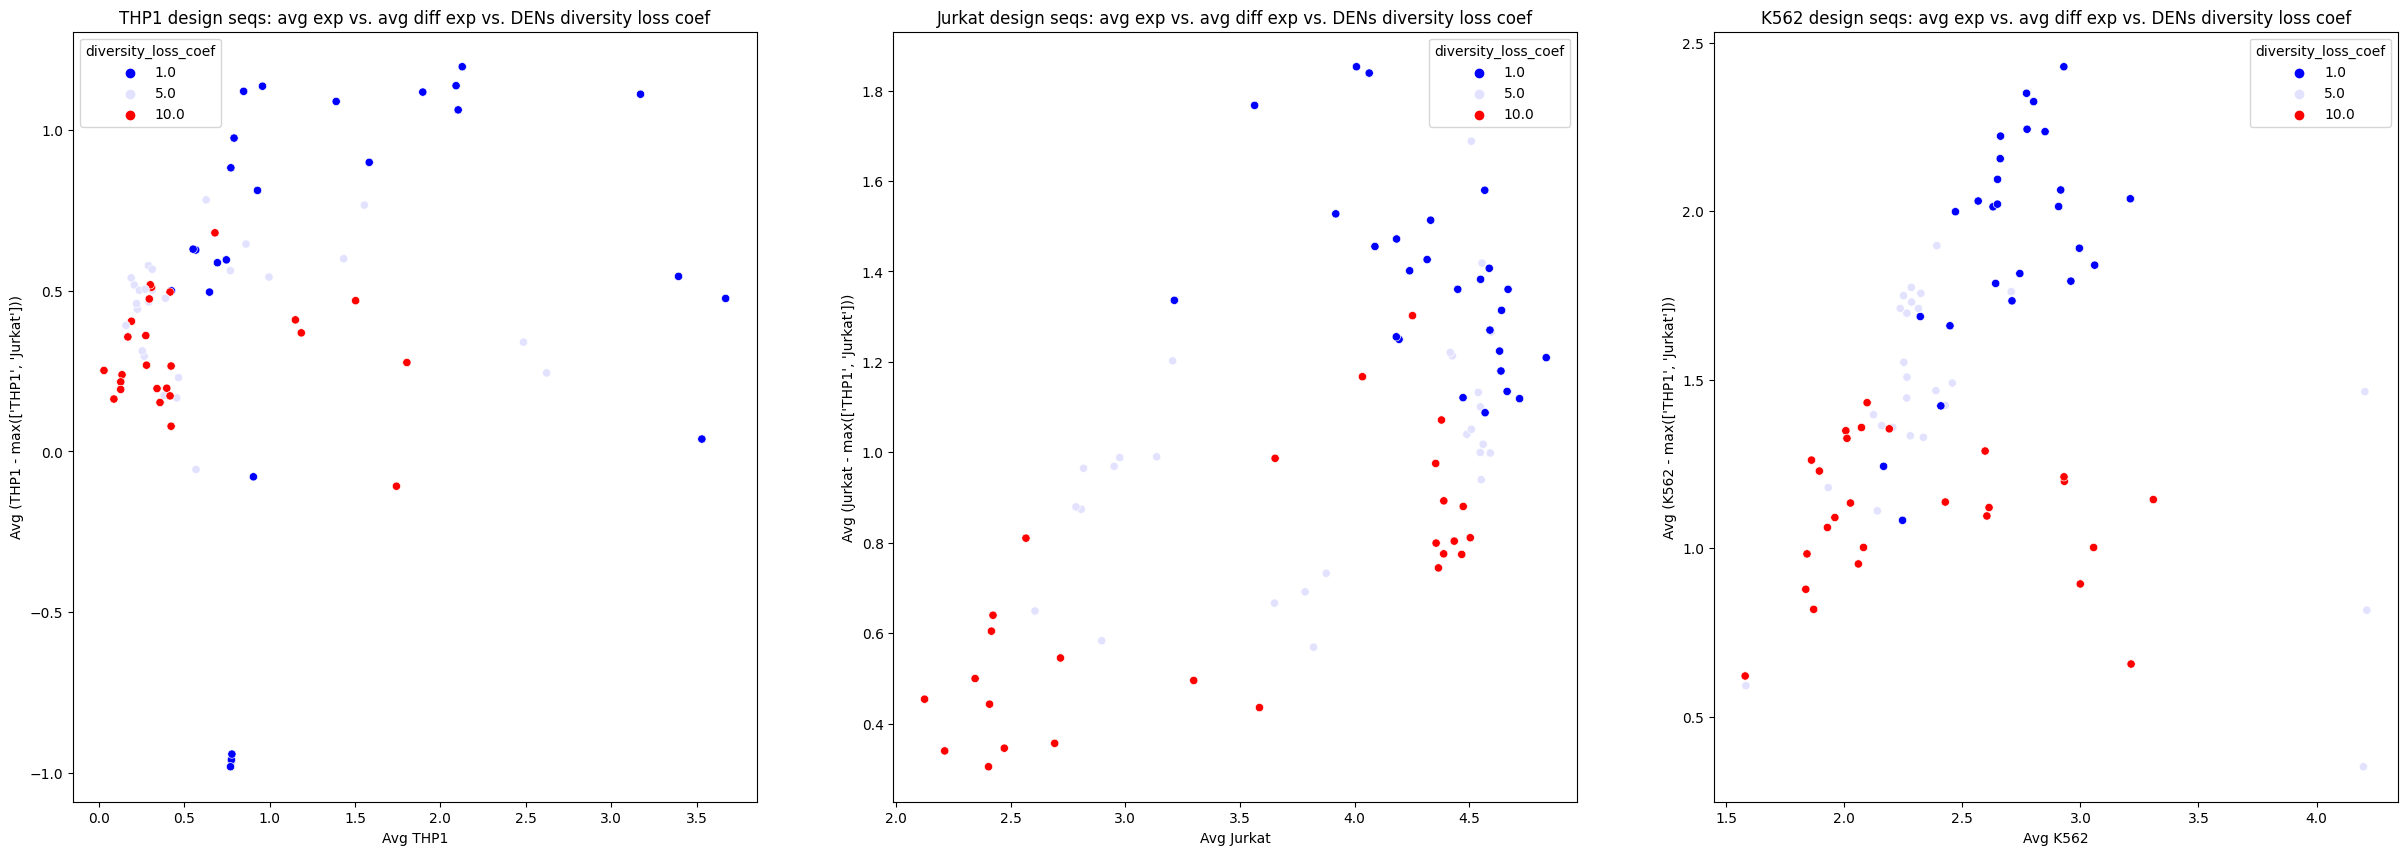

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10))

for i, cell in enumerate(all_cells):
    subset = all_pairwise_edit_distances[all_pairwise_edit_distances["designed_for"] == cell].reset_index(drop=True)
#     subset["index"] = subset.index
#     fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#     sns.scatterplot(data=subset, x="mean_pairwise_edit_distance", y="avg_diff", ax=ax[0], hue="index", legend=False, palette="Set1")
#     sns.scatterplot(data=subset, x="mean_pairwise_edit_distance", y="avg_target_cell_exp", ax=ax[1], hue="index", legend=False, palette="Set1")
#     fig.suptitle(cell)
#     plt.show()
    
#     fig = plt.figure()
# #     ax = Axes3D(fig)
#     ax = fig.add_subplot(projection='3d')
    
#     ax.scatter(subset["mean_pairwise_edit_distance"], subset["avg_diff"], subset["avg_target_cell_exp"])
#     ax.set_xlabel("mean_pairwise_edit_distance")    
#     ax.set_ylabel("avg_diff")    
#     ax.set_zlabel("avg_target_cell_exp")    
#     fig.suptitle(cell)
#     plt.show()

    sns.scatterplot(data=subset, x="avg_target_cell_exp", y="avg_diff", hue="diversity_loss_coef", palette="bwr", ax=ax[i])
    ax[i].set_title(f"{cell} design seqs: avg exp vs. avg diff exp vs. DENs diversity loss coef")
    ax[i].set_xlabel(f"Avg {cell}")
    ax[i].set_ylabel(f"Avg ({cell} - max({other_cells}))")

plt.show()

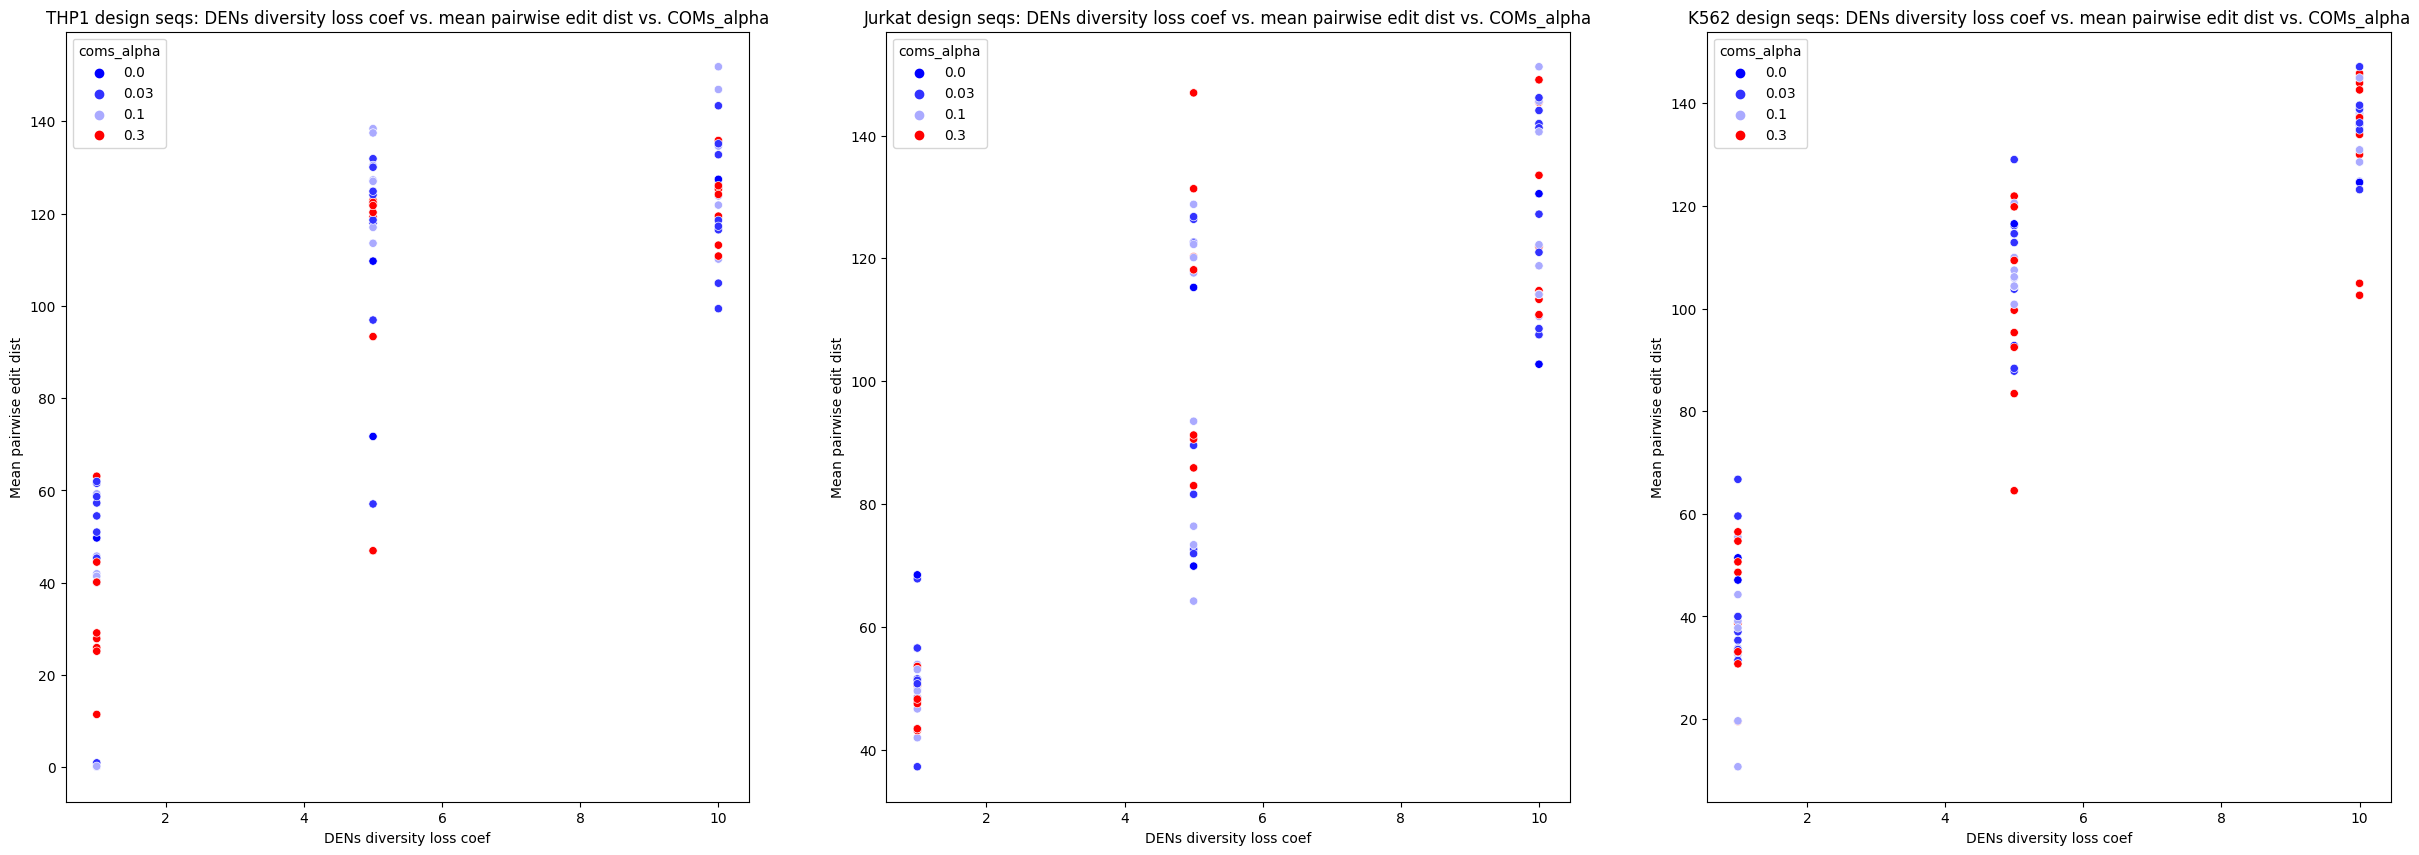

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10))

for i, cell in enumerate(all_cells):
    subset = all_pairwise_edit_distances[all_pairwise_edit_distances["designed_for"] == cell].reset_index(drop=True)
#     subset["index"] = subset.index
#     fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#     sns.scatterplot(data=subset, x="mean_pairwise_edit_distance", y="avg_diff", ax=ax[0], hue="index", legend=False, palette="Set1")
#     sns.scatterplot(data=subset, x="mean_pairwise_edit_distance", y="avg_target_cell_exp", ax=ax[1], hue="index", legend=False, palette="Set1")
#     fig.suptitle(cell)
#     plt.show()
    
#     fig = plt.figure()
# #     ax = Axes3D(fig)
#     ax = fig.add_subplot(projection='3d')
    
#     ax.scatter(subset["mean_pairwise_edit_distance"], subset["avg_diff"], subset["avg_target_cell_exp"])
#     ax.set_xlabel("mean_pairwise_edit_distance")    
#     ax.set_ylabel("avg_diff")    
#     ax.set_zlabel("avg_target_cell_exp")    
#     fig.suptitle(cell)
#     plt.show()

    sns.scatterplot(data=subset, x="diversity_loss_coef", y="mean_pairwise_edit_distance", hue="coms_alpha", palette="bwr", ax=ax[i])
    ax[i].set_title(f"{cell} design seqs: DENs diversity loss coef vs. mean pairwise edit dist vs. COMs_alpha")
    ax[i].set_xlabel(f"DENs diversity loss coef")
    ax[i].set_ylabel(f"Mean pairwise edit dist")

plt.show()

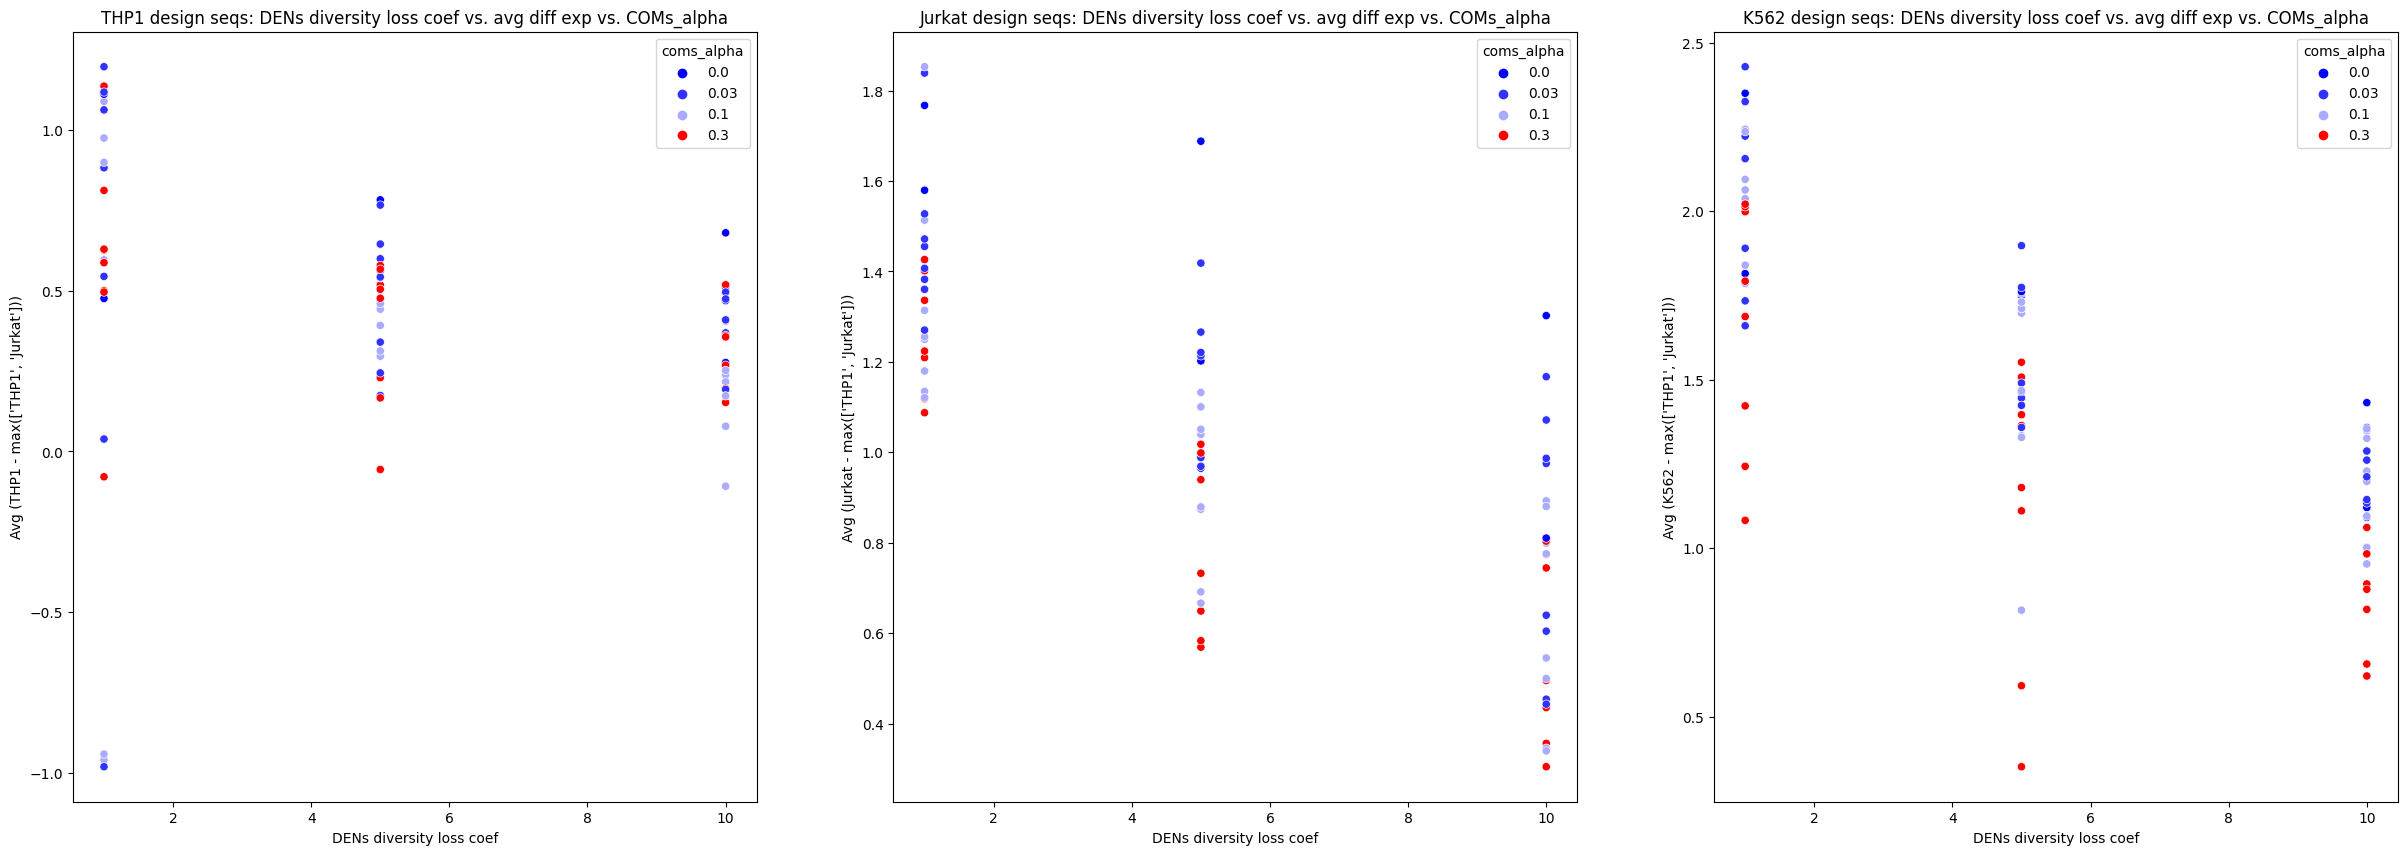

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10))

for i, cell in enumerate(all_cells):
    subset = all_pairwise_edit_distances[all_pairwise_edit_distances["designed_for"] == cell].reset_index(drop=True)
#     subset["index"] = subset.index
#     fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#     sns.scatterplot(data=subset, x="mean_pairwise_edit_distance", y="avg_diff", ax=ax[0], hue="index", legend=False, palette="Set1")
#     sns.scatterplot(data=subset, x="mean_pairwise_edit_distance", y="avg_target_cell_exp", ax=ax[1], hue="index", legend=False, palette="Set1")
#     fig.suptitle(cell)
#     plt.show()
    
#     fig = plt.figure()
# #     ax = Axes3D(fig)
#     ax = fig.add_subplot(projection='3d')
    
#     ax.scatter(subset["mean_pairwise_edit_distance"], subset["avg_diff"], subset["avg_target_cell_exp"])
#     ax.set_xlabel("mean_pairwise_edit_distance")    
#     ax.set_ylabel("avg_diff")    
#     ax.set_zlabel("avg_target_cell_exp")    
#     fig.suptitle(cell)
#     plt.show()

    sns.scatterplot(data=subset, x="diversity_loss_coef", y="avg_diff", hue="coms_alpha", palette="bwr", ax=ax[i])
    ax[i].set_title(f"{cell} design seqs: DENs diversity loss coef vs. avg diff exp vs. COMs_alpha")
    ax[i].set_xlabel(f"DENs diversity loss coef")
    ax[i].set_ylabel(f"Avg ({cell} - max({other_cells}))")

plt.show()

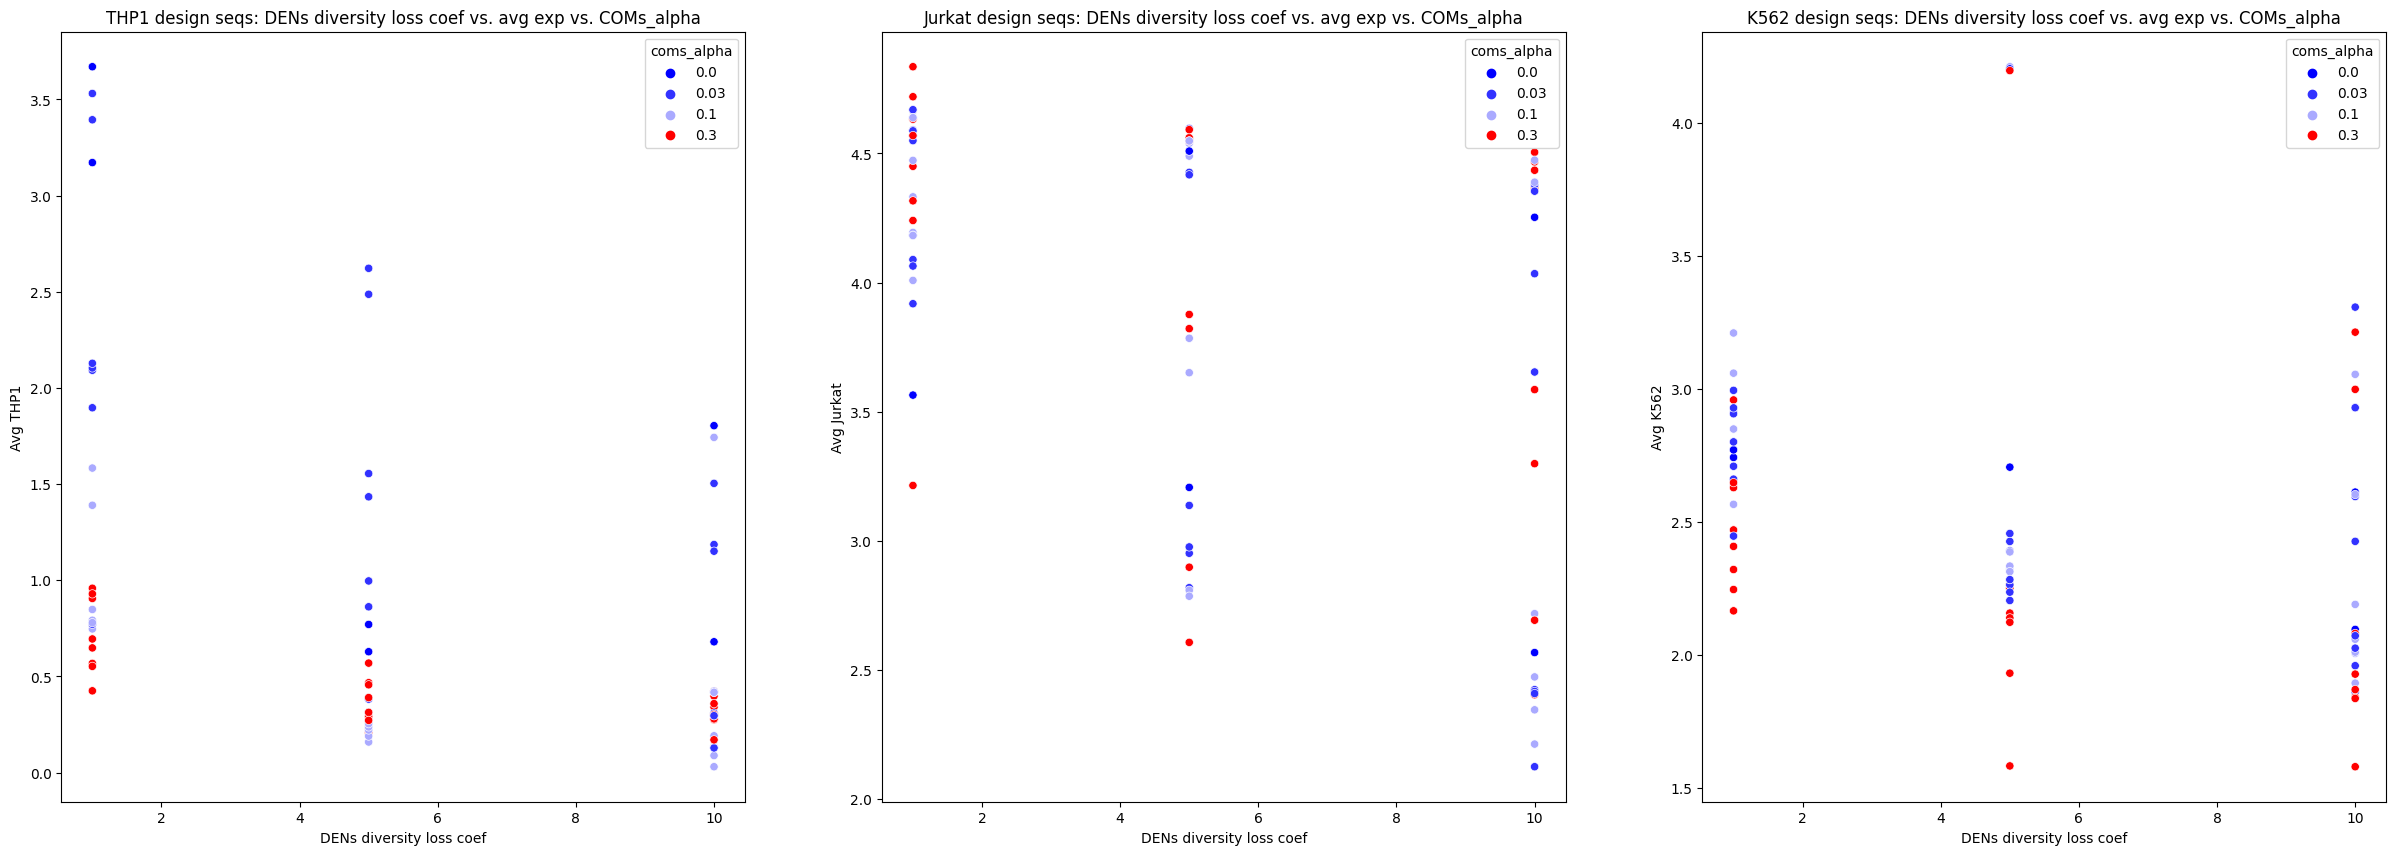

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10))

for i, cell in enumerate(all_cells):
    subset = all_pairwise_edit_distances[all_pairwise_edit_distances["designed_for"] == cell].reset_index(drop=True)
#     subset["index"] = subset.index
#     fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#     sns.scatterplot(data=subset, x="mean_pairwise_edit_distance", y="avg_diff", ax=ax[0], hue="index", legend=False, palette="Set1")
#     sns.scatterplot(data=subset, x="mean_pairwise_edit_distance", y="avg_target_cell_exp", ax=ax[1], hue="index", legend=False, palette="Set1")
#     fig.suptitle(cell)
#     plt.show()
    
#     fig = plt.figure()
# #     ax = Axes3D(fig)
#     ax = fig.add_subplot(projection='3d')
    
#     ax.scatter(subset["mean_pairwise_edit_distance"], subset["avg_diff"], subset["avg_target_cell_exp"])
#     ax.set_xlabel("mean_pairwise_edit_distance")    
#     ax.set_ylabel("avg_diff")    
#     ax.set_zlabel("avg_target_cell_exp")    
#     fig.suptitle(cell)
#     plt.show()

    sns.scatterplot(data=subset, x="diversity_loss_coef", y="avg_target_cell_exp", hue="coms_alpha", palette="bwr", ax=ax[i])
    ax[i].set_title(f"{cell} design seqs: DENs diversity loss coef vs. avg exp vs. COMs_alpha")
    ax[i].set_xlabel(f"DENs diversity loss coef")
    ax[i].set_ylabel(f"Avg {cell}")

plt.show()